In [10]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix

import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import GridSearchCV

3

In [11]:
iris = load_iris(as_frame=True)
data_completa = iris.data
data = data_completa[["sepal length (cm)", "sepal width (cm)"]]
labels = iris.target
X_train, X_test, y_train, y_test = train_test_split(
    data_completa, labels, stratify=labels, random_state=42
)
X_train_2D = X_train.loc[:,data_completa.columns.isin(["sepal length (cm)", "sepal width (cm)"])]
X_test_2D = X_test.loc[:,data_completa.columns.isin(["sepal length (cm)", "sepal width (cm)"])]

X_train_2D.shape

(112, 2)

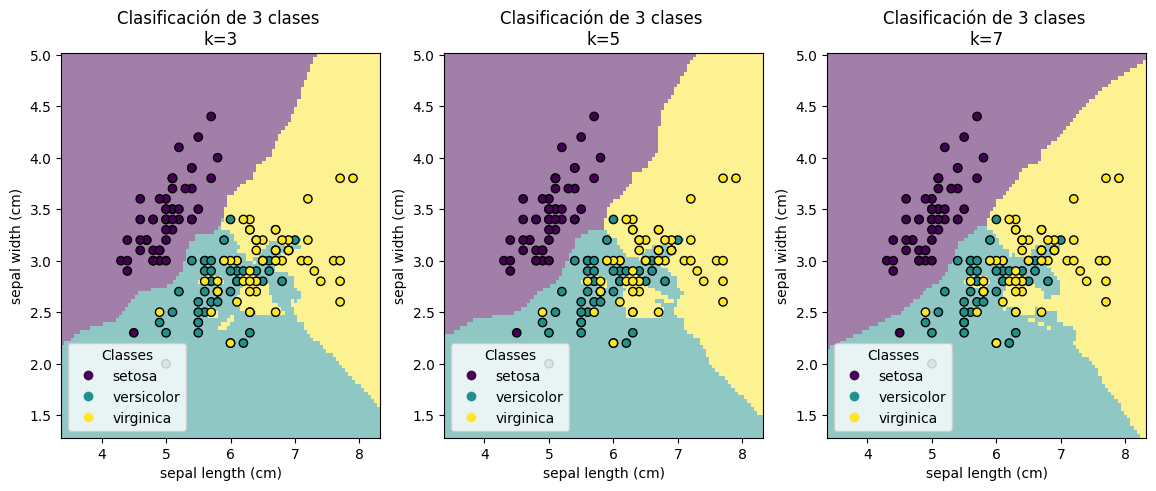

In [12]:
_, axs = plt.subplots(ncols=3, figsize=(14, 5))

for ax, k in zip(axs, (3, 5, 7)):
    clf = Pipeline(
        steps=[("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=k))]
    )
    #Uso weigth="distance". Otra opción: "uniform"
    clf.set_params(knn__weights = "distance").fit(X_train_2D, y_train)
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X_test_2D,
        response_method="predict",
        plot_method="pcolormesh",
        xlabel = iris.feature_names[0],
        ylabel = iris.feature_names[1],
        shading="auto",
        alpha=0.5,
        ax=ax,
    )
    scatter = disp.ax_.scatter(data.iloc[:, 0], data.iloc[:, 1], c = labels, edgecolors="k")
    disp.ax_.legend(
        scatter.legend_elements()[0],
        iris.target_names,
        loc="lower left",
        title="Classes",
    )
    _ = disp.ax_.set_title(
        f"Clasificación de 3 clases \nk={clf[-1].n_neighbors}"
    )

plt.show()

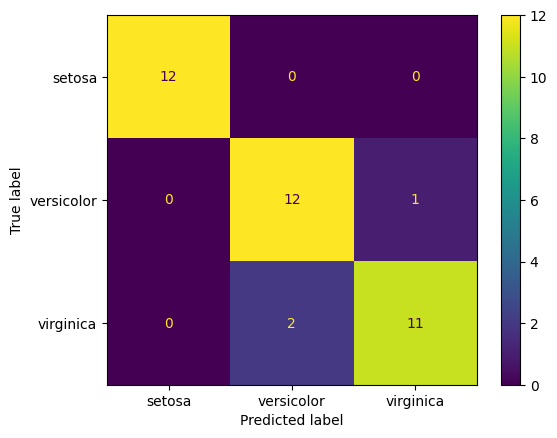

In [13]:
scaler = StandardScaler()
X_s_train = scaler.fit_transform(X_train)
X_s_test = scaler.transform(X_test)

model = GaussianNB()

model.fit(X_s_train, y_train)

y_pred = model.predict(X_s_test)

#print(classification_report(y_test, y_pred, target_names = iris.target_names))

labels = iris.target_names
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

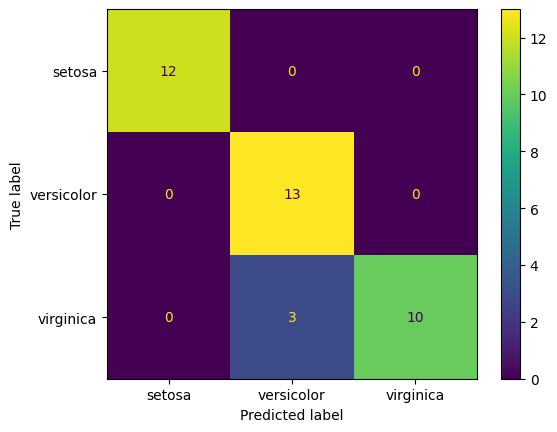

In [14]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)  # Puedes ajustar el número de vecinos según lo desees

# Entrenar el clasificador
knn_classifier.fit(X_s_train, y_train)

# Hacer predicciones sobre el conjunto de prueba
y_pred = knn_classifier.predict(X_s_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

In [15]:
class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE
    
    Parameters
    ----------
    bandwidth : float
        the kernel bandwidth within each class
    kernel : str
        the kernel name, passed to KernelDensity
    """
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
        
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                      kernel=self.kernel).fit(Xi)
                        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]
        return self
        
    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X)
                             for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)
        
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

{'bandwidth': 5.3366992312063095}
accuracy = 0.990353848272064


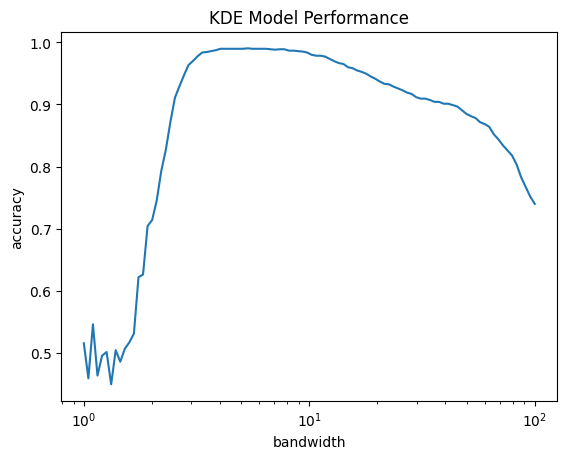

In [16]:
from sklearn.datasets import load_digits
digits = load_digits()
data = digits.data
target = digits.target

X_train, X_test, y_train, y_test = train_test_split(
    data, target, stratify = target, random_state=42
)

scaler = StandardScaler()
#X_s_train = scaler.fit_transform(X_train)
#X_s_test = scaler.transform(X_test)

bandwidths = 10 ** np.linspace(0, 2, 100)
grid = GridSearchCV(KDEClassifier(), {'bandwidth': bandwidths})
grid.fit(X_train, y_train)

scores = grid.cv_results_['mean_test_score']

plt.semilogx(bandwidths, scores)
plt.xlabel('bandwidth')
plt.ylabel('accuracy')
plt.title('KDE Model Performance')
print(grid.best_params_)
print('accuracy =', grid.best_score_)

              precision    recall  f1-score   support

           0       0.78      0.64      0.71        45
           1       0.68      0.57      0.62        46
           2       0.60      0.48      0.53        44
           3       0.44      0.52      0.48        46
           4       0.78      0.69      0.73        45
           5       0.21      0.28      0.24        46
           6       0.80      0.44      0.57        45
           7       0.44      0.33      0.38        45
           8       0.23      0.26      0.24        43
           9       0.32      0.56      0.41        45

    accuracy                           0.48       450
   macro avg       0.53      0.48      0.49       450
weighted avg       0.53      0.48      0.49       450



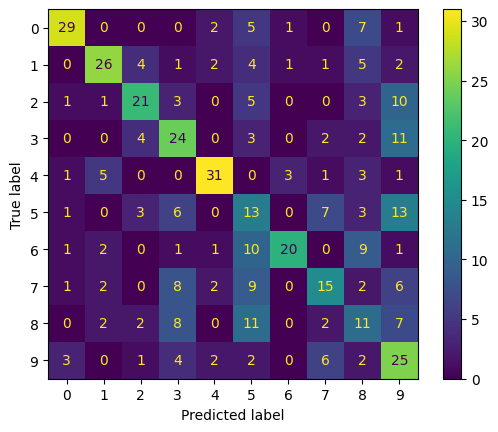

In [17]:
model = KDEClassifier(bandwidth=1.0, kernel="gaussian")

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, target_names = [str(name) for name in digits.target_names]))

labels = digits.target_names
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       0.94      1.00      0.97        46
           2       1.00      1.00      1.00        44
           3       0.98      1.00      0.99        46
           4       0.98      1.00      0.99        45
           5       1.00      0.98      0.99        46
           6       1.00      1.00      1.00        45
           7       1.00      1.00      1.00        45
           8       0.97      0.91      0.94        43
           9       0.98      0.96      0.97        45

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



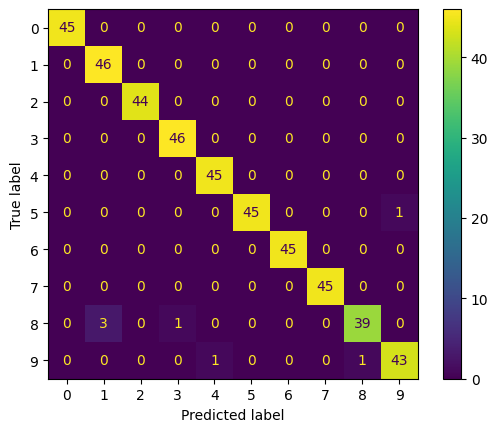

In [18]:
model = KDEClassifier(bandwidth=5.3366992312063095, kernel="gaussian")

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, target_names = [str(name) for name in digits.target_names]))

labels = digits.target_names
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

Estandarizado

C:\Users\pedro\AppData\Local\Temp\ipykernel_34404\1348271375.py:29: RuntimeWarning: invalid value encountered in divide
  return result / result.sum(1, keepdims=True)
C:\Users\pedro\AppData\Local\Temp\ipykernel_34404\1348271375.py:29: RuntimeWarning: invalid value encountered in divide
  return result / result.sum(1, keepdims=True)
C:\Users\pedro\AppData\Local\Temp\ipykernel_34404\1348271375.py:29: RuntimeWarning: invalid value encountered in divide
  return result / result.sum(1, keepdims=True)
C:\Users\pedro\AppData\Local\Temp\ipykernel_34404\1348271375.py:29: RuntimeWarning: invalid value encountered in divide
  return result / result.sum(1, keepdims=True)
C:\Users\pedro\AppData\Local\Temp\ipykernel_34404\1348271375.py:29: RuntimeWarning: invalid value encountered in divide
  return result / result.sum(1, keepdims=True)
C:\Users\pedro\AppData\Local\Temp\ipykernel_34404\1348271375.py:29: RuntimeWarning: invalid value encountered in divide
  return result / result.sum(1, keepdims=True

{'bandwidth': 1.238594915656081}
accuracy = 0.9747597411537932


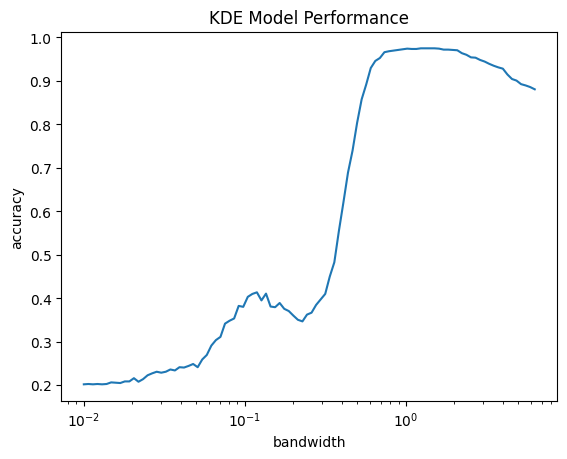

In [23]:
scaler = StandardScaler()
X_s_train = scaler.fit_transform(X_train)
X_s_test = scaler.transform(X_test)

bandwidths = 10 ** np.linspace(-2, 0.8, 100)
grid = GridSearchCV(KDEClassifier(), {'bandwidth': bandwidths})
grid.fit(X_s_train, y_train)

scores = grid.cv_results_['mean_test_score']

plt.semilogx(bandwidths, scores)
plt.xlabel('bandwidth')
plt.ylabel('accuracy')
plt.title('KDE Model Performance')
print(grid.best_params_)
print('accuracy =', grid.best_score_)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        45
           1       0.94      0.98      0.96        46
           2       1.00      1.00      1.00        44
           3       0.96      1.00      0.98        46
           4       0.98      0.96      0.97        45
           5       1.00      0.96      0.98        46
           6       0.98      1.00      0.99        45
           7       0.96      1.00      0.98        45
           8       0.97      0.88      0.93        43
           9       0.95      0.93      0.94        45

    accuracy                           0.97       450
   macro avg       0.97      0.97      0.97       450
weighted avg       0.97      0.97      0.97       450



C:\Users\pedro\AppData\Local\Temp\ipykernel_34404\1348271375.py:29: RuntimeWarning: invalid value encountered in divide
  return result / result.sum(1, keepdims=True)


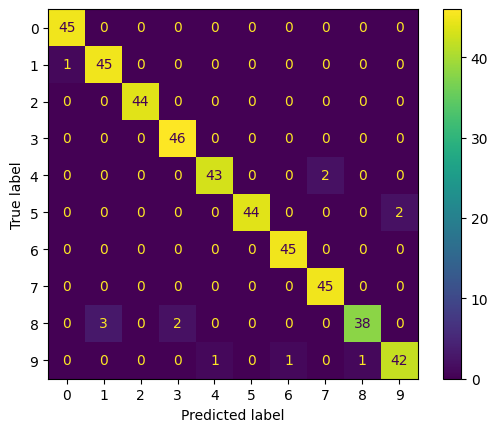

In [24]:
model = KDEClassifier(bandwidth= 1.238594915656081, kernel="gaussian")

model.fit(X_s_train, y_train)

y_pred = model.predict(X_s_test)

print(classification_report(y_test, y_pred, target_names = [str(name) for name in digits.target_names]))

labels = digits.target_names
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

              precision    recall  f1-score   support

           0       0.10      1.00      0.18        45
           1       0.00      0.00      0.00        46
           2       1.00      0.05      0.09        44
           3       0.00      0.00      0.00        46
           4       0.00      0.00      0.00        45
           5       0.00      0.00      0.00        46
           6       0.00      0.00      0.00        45
           7       0.00      0.00      0.00        45
           8       0.00      0.00      0.00        43
           9       1.00      0.13      0.24        45

    accuracy                           0.12       450
   macro avg       0.21      0.12      0.05       450
weighted avg       0.21      0.12      0.05       450



C:\Users\pedro\AppData\Local\Temp\ipykernel_34404\1348271375.py:29: RuntimeWarning: invalid value encountered in divide
  return result / result.sum(1, keepdims=True)
C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pe

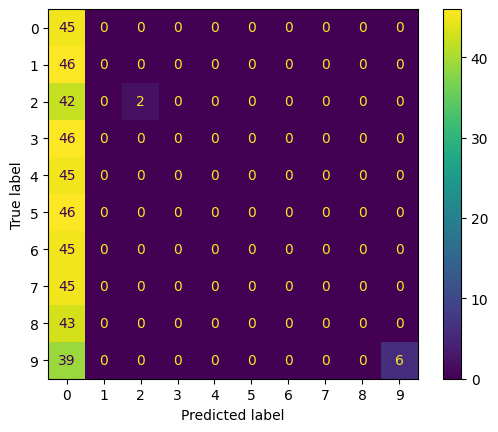

In [22]:
model = KDEClassifier(bandwidth=10**-1.8, kernel="gaussian")

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, target_names = [str(name) for name in digits.target_names]))

labels = digits.target_names
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()